In [1]:
##Loading data
import os
import csv


samples = [] 

with open('./data/driving_log.csv') as csvfile: 
    reader = csv.reader(csvfile)
    next(reader, None) #incase of heading
    for line in reader:
        samples.append(line)

In [2]:
#Train/Validation split for the data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


train_samples, validation_samples = train_test_split(samples,test_size=0.15)

In [3]:
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt


def generator(samples, batch_size=32):
    num_samples = len(samples)
   
    while 1: 
        shuffle(samples) #shuffle
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                    for i in range(0,3): #images corresponding to each camera
                        
                        name = './data/IMG/'+batch_sample[i].split('/')[-1]
                        center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) #BGR to RGB
                        center_angle = float(batch_sample[3]) #steering angle
                        images.append(center_image)
                        
                        #Correction Factor 0.2
                        
                        if(i==0):
                            angles.append(center_angle)
                        elif(i==1):
                            angles.append(center_angle+0.2)
                        elif(i==2):
                            angles.append(center_angle-0.2)
                        
                        # Data Augumentation(flip)
                        images.append(cv2.flip(center_image,1))
                        if(i==0):
                            angles.append(center_angle*-1)
                        elif(i==1):
                            angles.append((center_angle+0.2)*-1)
                        elif(i==2):
                            angles.append((center_angle-0.2)*-1) 
        
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train) 

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers import Lambda, Cropping2D

model = Sequential()

# Preprocessing the incoming data (normalize)
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# cropping images
model.add(Cropping2D(cropping=((70,25),(0,0))))           

#layer 1- Convolution, number of filters- 24, filter size= 5x5, stride= 2x2
model.add(Conv2D(24, (5, 5), strides=(2, 2)))
model.add(Activation('elu'))

#layer 2- Convolution, number of filters- 36, filter size= 5x5, stride= 2x2
model.add(Conv2D(36, (5, 5), strides=(2, 2)))
model.add(Activation('elu'))

#layer 3- Convolution, number of filters- 48, filter size= 5x5, stride= 2x2
model.add(Conv2D(48, (5, 5), strides=(2, 2)))
model.add(Activation('elu'))

#layer 4- Convolution, number of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))

#layer 5- Convolution, number of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))

#flatten image from 2D to side by side
model.add(Flatten())

#layer 6- fully connected layer 1
model.add(Dense(100))
model.add(Activation('elu'))

#Adding a dropout layer to avoid overfitting.
model.add(Dropout(0.25))

#layer 7- fully connected layer 1
model.add(Dense(50))
model.add(Activation('elu'))


#layer 8- fully connected layer 1
model.add(Dense(10))
model.add(Activation('elu'))

#layer 9- fully connected layer 1
model.add(Dense(1)) #regression o/p


# the output is the steering angle
# using mean squared error loss function is the right choice for this regression problem
# adam optimizer 
model.compile(loss='mse',optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator,   nb_val_samples=len(validation_samples), nb_epoch=5, verbose=1)

#saving model
model.save('model.h5')

# keras method to print the model summary
model.summary()

C:\Users\Arpit Pandey\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Arpit Pandey\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, steps_per_epoch=6829, epochs=5, validation_steps=1206)`


Epoch 1/5
6829/6829 [==============================] - 2257s 330ms/step - loss: 0.0110 - val_loss: 0.0200
Epoch 2/5
6829/6829 [==============================] - 2157s 316ms/step - loss: 0.0040 - val_loss: 0.0163
Epoch 3/5
6829/6829 [==============================] - 2143s 314ms/step - loss: 0.0025 - val_loss: 0.0168
Epoch 4/5
6829/6829 [==============================] - 2144s 314ms/step - loss: 0.0019 - val_loss: 0.0161
Epoch 5/5
6829/6829 [==============================] - 2143s 314ms/step - loss: 0.0015 - val_loss: 0.0156
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 158, 24)       1824      
________

dict_keys(['val_loss', 'loss'])


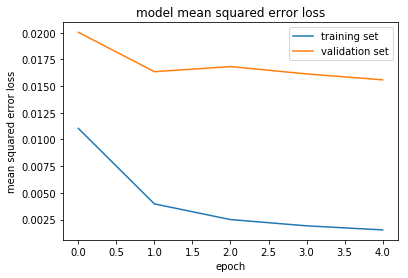

In [6]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()